In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import networkx as nx
import pandas as pd
from tqdm import tqdm
from SmilesPE.pretokenizer import atomwise_tokenizer

In [2]:
def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   formal_charge=atom.GetFormalCharge(),
                   chiral_tag=atom.GetChiralTag(),
                   hybridization=atom.GetHybridization(),
                   num_explicit_hs=atom.GetNumExplicitHs(),
                   is_aromatic=atom.GetIsAromatic())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
    return G

def nx_to_mol(G):
    mol = Chem.RWMol()
    atomic_nums = nx.get_node_attributes(G, 'atomic_num')
    chiral_tags = nx.get_node_attributes(G, 'chiral_tag')
    formal_charges = nx.get_node_attributes(G, 'formal_charge')
    node_is_aromatics = nx.get_node_attributes(G, 'is_aromatic')
    node_hybridizations = nx.get_node_attributes(G, 'hybridization')
    num_explicit_hss = nx.get_node_attributes(G, 'num_explicit_hs')
    node_to_idx = {}
    for node in G.nodes():
        a=Chem.Atom(atomic_nums[node])
        a.SetChiralTag(chiral_tags[node])
        a.SetFormalCharge(formal_charges[node])
        a.SetIsAromatic(node_is_aromatics[node])
        a.SetHybridization(node_hybridizations[node])
        a.SetNumExplicitHs(num_explicit_hss[node])
        idx = mol.AddAtom(a)
        node_to_idx[node] = idx

    bond_types = nx.get_edge_attributes(G, 'bond_type')
    for edge in G.edges():
        first, second = edge
        ifirst = node_to_idx[first]
        isecond = node_to_idx[second]
        bond_type = bond_types[first, second]
        mol.AddBond(ifirst, isecond, bond_type)

    Chem.SanitizeMol(mol)
    return mol

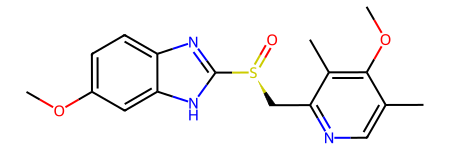

In [3]:
smi = 'COc1ccc2c(c1)[nH]c(n2)[S@@](=O)Cc1ncc(c(c1C)OC)C'
mol = Chem.MolFromSmiles(smi)
mol

In [4]:
g = mol_to_nx(mol)
bfs = nx.bfs_tree(g, source = 0)
dfs = nx.dfs_tree(g, source = 0)

In [5]:
print([i for i in bfs])
print([i for i in dfs])
# print([g.nodes[i]['atomic_num'] for i in bfs])
# print([g.nodes[i]['atomic_num'] for i in dfs])

[0, 1, 2, 3, 7, 4, 6, 5, 8, 10, 9, 11, 12, 13, 14, 15, 19, 16, 18, 20, 17, 21, 23, 22]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [6]:
print([atom.GetIdx() for atom in mol.GetAtoms()])
# print([atom.GetAtomicNum() for atom in mol.GetAtoms()])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [7]:
tokens = atomwise_tokenizer(smi)
print(len(tokens))
print(tokens)

41
['C', 'O', 'c', '1', 'c', 'c', 'c', '2', 'c', '(', 'c', '1', ')', '[nH]', 'c', '(', 'n', '2', ')', '[S@@]', '(', '=', 'O', ')', 'C', 'c', '1', 'n', 'c', 'c', '(', 'c', '(', 'c', '1', 'C', ')', 'O', 'C', ')', 'C']


In [8]:
grammar = ['[', ']', '(', ')', '=', '.', '/', '\\', '-', '#'] + [str(i) for i in range(10)]

In [9]:
positions = []
atom_idx = 0
grammar_idx = 0
for tok in tokens:
    if tok in grammar:
        positions.append(None)
        grammar_idx += 1
    else:
        positions.append((list(dfs)[atom_idx], list(bfs)[atom_idx]))
        atom_idx += 1

In [10]:
for tok, pos in zip(tokens[:15], positions[:15]):
    print(tok, pos)

C (0, 0)
O (1, 1)
c (2, 2)
1 None
c (3, 3)
c (4, 7)
c (5, 4)
2 None
c (6, 6)
( None
c (7, 5)
1 None
) None
[nH] (8, 8)
c (9, 10)


In [11]:
for tok, pos in zip(tokens[15:], positions[15:]):
    print(tok, pos)

( None
n (10, 9)
2 None
) None
[S@@] (11, 11)
( None
= None
O (12, 12)
) None
C (13, 13)
c (14, 14)
1 None
n (15, 15)
c (16, 19)
c (17, 16)
( None
c (18, 18)
( None
c (19, 20)
1 None
C (20, 17)
) None
O (21, 21)
C (22, 23)
) None
C (23, 22)


In [12]:
df = pd.read_pickle('processed.pickle')
reactants = df['reactants_mol'].apply(lambda x: '.'.join(x))
products  = df['products_mol'].apply(lambda x: '.'.join(x))
r_tokens = []
p_tokens = []

In [13]:
for i, (r, p) in enumerate(tqdm(zip(reactants, products), total=len(reactants))):
    r_toks = atomwise_tokenizer(r)
    p_toks = atomwise_tokenizer(p)

100%|██████████| 50037/50037 [00:00<00:00, 55196.41it/s]


In [15]:
print(r_toks)
print(p_toks)

['C', 'O', 'C', '(', '=', 'O', ')', 'c', '1', 'c', 'c', '(', 'Br', ')', 'c', '(', 'F', ')', 'c', '(', 'F', ')', 'c', '1', 'N', 'c', '1', 'c', 'c', 'c', 'c', 'c', '1', 'F', '.', 'C', 'O', 'c', '1', 'c', 'c', 'c', '(', 'C', 'S', ')', 'c', 'c', '1']
['C', 'O', 'C', '(', '=', 'O', ')', 'c', '1', 'c', 'c', '(', 'S', 'C', 'c', '2', 'c', 'c', 'c', '(', 'O', 'C', ')', 'c', 'c', '2', ')', 'c', '(', 'F', ')', 'c', '(', 'F', ')', 'c', '1', 'N', 'c', '1', 'c', 'c', 'c', 'c', 'c', '1', 'F']
